# Tema 4: Combinación Lineal de Unitarias


Curso IAC02.

Autor: Alejandro Mata Ali

En este notebook vamos a implementar la combinación lineal de unitarias para diferentes operadores y estados.

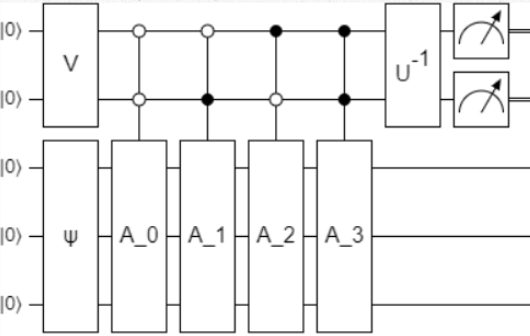

## Librerías

In [ ]:
%%capture
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits para el estado y m qubits para las amplitudes del LCU. Además, introduciremos una lista de operadores y otra de amplitudes de cada operador. El m se deduce de la longitud de estas listas.

In [ ]:
from qiskit.circuit.library import StatePreparation

In [ ]:
def LCU(n:int,operator_list, amplitudes_list):
    #Obtenemos el m
    m = int(np.ceil(np.log2(len(amplitudes_list))))
    #Registros
    qr = QuantumRegister(n, 'State')
    LCUr = QuantumRegister(m, 'LCUr')

    #Circuito
    qc = QuantumCircuit(LCUr, qr, name='LCU')

    #Amplitudes de V, la raíz cuadrada de los modulos de las amplitudes
    amplitudesV = np.sqrt(abs(amplitudes_list))

    #Si faltan elementos, añadimos 0 al final
    if len(amplitudesV) != 2**m:
        amplitudesV = np.append(amplitudesV, np.zeros(2**m-len(amplitudesV)))

    #Preparamos los qubits LCU
    V = StatePreparation(amplitudesV, normalize=True)
    qc.append(V, LCUr)

    #Vamos aplicando de manera controlada las puertas
    for i in range(len(amplitudes_list)):
        #Para seleccionar los controles adecuados, vamos a poner X cuanto haya 0
        binario = bin(i)[2:]
        binario = ('0'*(m-len(binario)) + binario)[::-1] #Añadimos 0 iniciales y le damos la vuelta
        for j, bit in enumerate(binario):
            if bit == '0': qc.x(j)
        qc.append(operator_list[i].control(m), LCUr[:]+qr[:])
        for j, bit in enumerate(binario):#Deshacemos
            if bit == '0': qc.x(j)

    #Deshacemos la inicialización
    qc.append(V.inverse(), LCUr)

    #Convertimos en gate
    LCU_Gate = qc.to_gate()

    return LCU_Gate

Creamos dos unitarias de prueba. Estas serán $\mathbb{I}\otimes X$ y $X\otimes \mathbb{I}$. El operador total será:

$A = \frac{1}{3}\mathbb{I}\otimes X + \frac{2}{3}X\otimes \mathbb{I}$

In [ ]:
n = 2
amplitudes_list = np.array([1/3,2/3])

unitary_circuit1 = QuantumCircuit(n, name='A1')
unitary_circuit2 = QuantumCircuit(n, name='A2')

unitary_circuit1.x(1)
unitary_circuit2.x(0)

unitary1 = unitary_circuit1.to_gate()
unitary2 = unitary_circuit2.to_gate()

operator_list = [unitary1, unitary2]

Veamos el circuito obtenido.

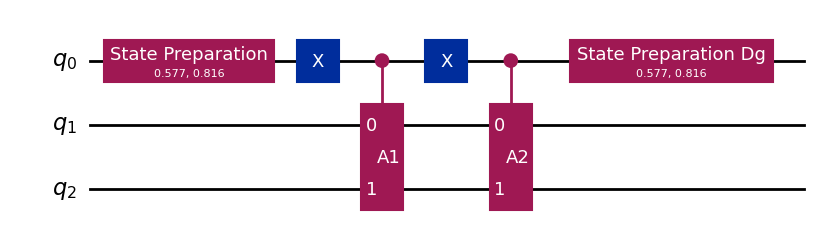

In [ ]:
qc = QuantumCircuit(n+1)
#Llamamos directamente a la puerta, sin necesidad de guardarla
qc.append(LCU(n,operator_list,amplitudes_list), range(n+1))

#Descomponemos para ver el circuito
qc2 = qc.decompose(['LCU'], reps=2)
qc2.draw('mpl')

Vamos a aplicarla sobre un estado concreto y mediremos los dos primeros qubits para ver si obtenemos aquello que buscamos.

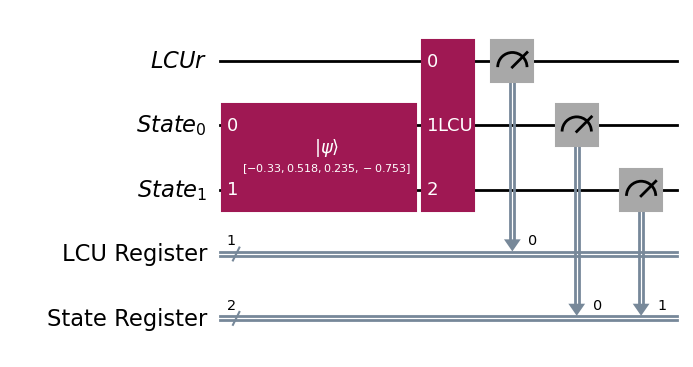

In [ ]:
#Empezamos en un estado cualquiera
state = np.array([-0.35,0.55,0.25,-0.8])
state /= np.linalg.norm(state)

#Circuito cuantico
qr   = QuantumRegister(n, name='State')
LCUr = QuantumRegister(1, name='LCUr')

crState = ClassicalRegister(n, name='State Register')
crLCU   = ClassicalRegister(1, name='LCU Register')

qc = QuantumCircuit(LCUr, qr, crLCU, crState, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)

#Aplicamos la QPE
qc.append(LCU(n,operator_list,amplitudes_list), LCUr[:]+qr[:])

#Medimos los qubits
qc.measure(LCUr, crLCU)
qc.measure(qr, crState)

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


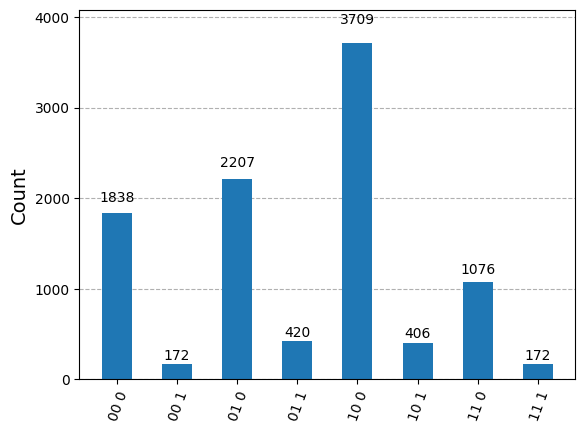

In [ ]:
#Número de shots
n_shots = 10000

#Simulador de n+m qubits
backend = GenericBackendV2(num_qubits=n+1)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que si el qubit LCU está en 0, tenemos muchas cuentas, pero si está en 1, tenemos pocas. Recordemos que la probabilidad de obtener el 0 es dado por

$\langle A^2 \rangle$

In [ ]:
#Creamos el operador A
X = np.array([[0,1],[1,0]])
A = amplitudes_list[0]*np.kron(X,np.eye(2)) + amplitudes_list[1]*np.kron(np.eye(2), X)

#Hacemos el valor esperado de su cuadrado
prob0 = state @ A@A @ state
print('Probabilidad de obtener 0 ', prob0)

#Calculamos con las cuentas
cuentas0 = [ counts[key] for key in counts if key[-1] == '0' ] #Cuentas si acabamos en 0
frec0 = sum(cuentas0)/n_shots

print('Frecuencia de obtener 0 ', frec0)

Probabilidad de obtener 0  0.8847006651884701
Frecuencia de obtener 0  0.883


Vemos que coinciden. Vamos a ver el estado después de aplicar el operador.

In [ ]:
#Primero el estado teórico
new_state = A @ state

print('Probabilidades teóricas: ', new_state**2)

#Ahora el estado obtenido
state_0 = { key[:-2]: counts[key]/(n_shots) for key in counts if key[-1] == '0' } #Cuentas si acabamos en 0 normalizadas

vector_0 = np.zeros(2**n)

for i in state_0:
    vector_0[int(i,2)] = state_0[i]

print('Probabilidades obtenidas: ', vector_0)


Probabilidades teóricas:  [0.17960089 0.22172949 0.37472284 0.10864745]
Probabilidades obtenidas:  [0.1838 0.2207 0.3709 0.1076]


Vemos que las probabilidaddes coinciden bien.

---
# Ejercicio

Haz la misma prueba con otros operadores con más qubits.